In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

## Load data

In [19]:
# Copy results of NF here
import subprocess

#subprocess.run(["cp", "/Users/katianakontolati/PycharmProjects/pytorch-flows/results/results.npz", "data/"])
#subprocess.run(["cp", "/Users/katianakontolati/Documents/Johns Hopkins University/1.PhD/LANL-Research/Research/ChemCam_data/Mixed_data/NF_mixed_train_test_data.npz", "data/"])
#subprocess.run(["cp", "/Users/katianakontolati/Documents/Johns Hopkins University/1.PhD/LANL-Research/Research/ChemCam_data/calibration_data/calibration_data.npz", "data/"])

CompletedProcess(args=['cp', '/Users/katianakontolati/Documents/Johns Hopkins University/1.PhD/LANL-Research/Research/ChemCam_data/calibration_data/calibration_data.npz', 'data/'], returncode=0)

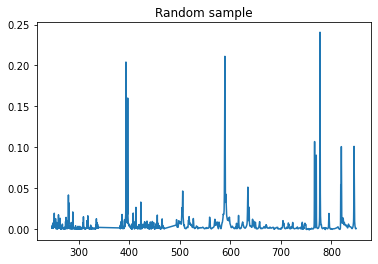

(426, 5606)

In [3]:
# Get calibration samples and labels 

# Load observations
file = np.load('data/NF_mixed_train_test_data.npz')  
calib_data = file['y_calib'] # get earth data after earth_2_mars transform

# Load wavelengths
w = file['w']
plt.plot(w, calib_data[0,:])
plt.title('Random sample')
plt.show()
calib_data.shape

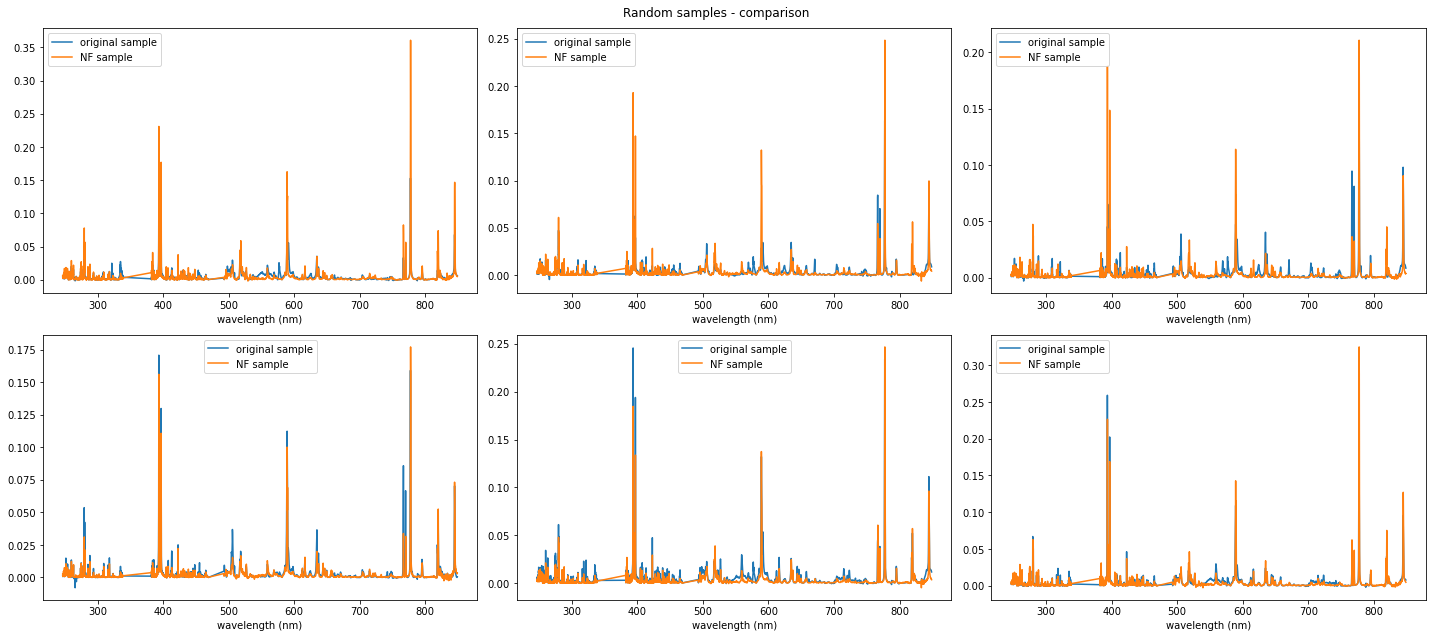

In [4]:
# Load results from NF training
file1 = np.load('data/results.npz') 
calib_data_gaussian = file1['z'] # load calibration data to gaussian (X --> Z)

# Load noise and corresponding LIBS spectra (Z --> X)
noise = file1['noise']
libs_from_noise = file1['forward_flow']

# Plot samples in two random dimensions
#plt.scatter(calib_data_gaussian[:,1], calib_data_gaussian[:,2]) # notice a few outliers
#plt.show()

# Compare an original LIBS sample with one generated with the NF model
# Plot before normalization
fig = plt.figure(figsize=(20, 9), facecolor='white')

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    rr = np.random.randint(0,400)
    plt.plot(w, calib_data[rr,:], label='original sample')
    plt.plot(w, libs_from_noise[rr,:], label='NF sample')
    #plt.ylim(0,0.25)
    plt.legend()
    plt.xlabel('wavelength (nm)')
plt.suptitle('Random samples - comparison')
fig.tight_layout()
plt.show()

In [5]:
# Load compositions
file2 = np.load('data/calibration_data.npz')
comp = file2['c']
comp.shape

(426, 8)

## Train linear regressor models for each oxide

### PLS regression

In [29]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor

# train 8 models, one for each oxide
split = 400

# PLS
#max_comp = 50
#models_best, scores_best = [0]*comp.shape[1], [0]*comp.shape[1]
# for j in range(comp.shape[1]):
#     curr_best = 0
#     for i in range(max_comp):
#         n_comp = i+1
#         pls = PLSRegression(n_components=n_comp, max_iter=3000, tol=1e-4)
#         pls.fit(calib_data[:split], comp[:split,j])
#         score = pls.score(calib_data[split:], comp[split:,j]) # test on remaining samples
#         if score > curr_best:
#             curr_best = score
#             models_best[j] = pls
#             scores_best[j] = curr_best      

# NN
models_best, scores_best = [], []
for j in range(comp.shape[1]):
    mlp = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=500).fit(calib_data[:split], comp[:split,j])
    score = mlp.score(calib_data[split:], comp[split:,j]) # test on remaining samples
    models_best.append(mlp)
    scores_best.append(score)
    print('Training of model {} completed'.format(j+1))
    print('score:', score)
    print('')

/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training of model 1 completed
score: 0.4696180639706595

Training of model 2 completed
score: 0.7470637960797815



/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training of model 3 completed
score: 0.7493699751003027



/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training of model 4 completed
score: 0.8202828435015348



/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training of model 5 completed
score: 0.8958862275615384



/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training of model 6 completed
score: 0.8447007200245049

Training of model 7 completed
score: 0.8436754333722593

Training of model 8 completed
score: 0.6896870133393909



/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [30]:
scores_best

[0.4696180639706595,
 0.7470637960797815,
 0.7493699751003027,
 0.8202828435015348,
 0.8958862275615384,
 0.8447007200245049,
 0.8436754333722593,
 0.6896870133393909]

In [63]:
# For PLS only
#for i in range(comp.shape[1]):
#    print('# of comp. for model {}: {}'.format(i+1, models_best[i].get_params()['n_components']))

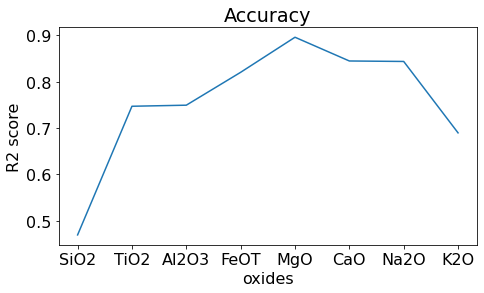

In [33]:
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']
plt.figure(figsize=(7.5,4))
plt.rcParams.update({'font.size': 16})
plt.plot(oxides, scores_best)
plt.ylabel('R2 score')
plt.xlabel('oxides')
plt.title('Accuracy')
plt.show()

## Uncertainty quantification (UQ)

### Choose nearest neighbors and compute uncertainty of predictions

In [34]:
print(noise.shape, libs_from_noise.shape)

(10000, 5606) (10000, 5606)


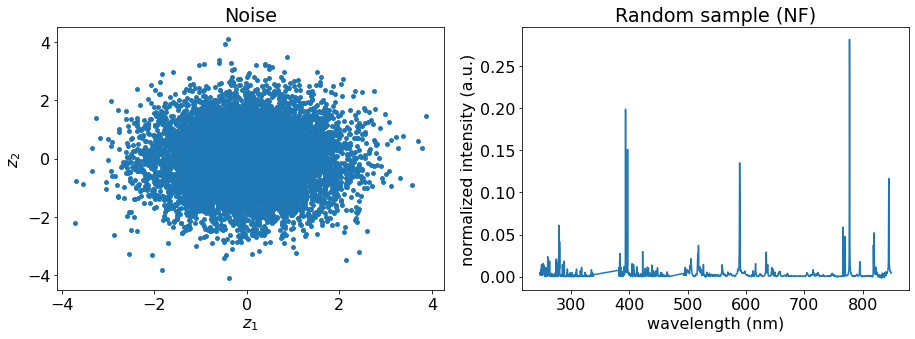

In [35]:
fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.scatter(noise[:,0], noise[:,1], s=15)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Noise')
plt.subplot(1,2,2)
plt.plot(w, libs_from_noise[0,:])
plt.xlabel('wavelength (nm)')
plt.ylabel('normalized intensity (a.u.)')
plt.title('Random sample (NF)')
fig.tight_layout()
plt.show()

In [70]:
# Choose one point and find its k-nearest neighbors
n_neighbors = 5
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, p=2)
knn.fit(noise)

rand_sample = np.random.randint(0,noise.shape[0])
nn = knn.kneighbors(X=noise[rand_sample,:].reshape(1, -1), n_neighbors=n_neighbors, return_distance=False) # indices

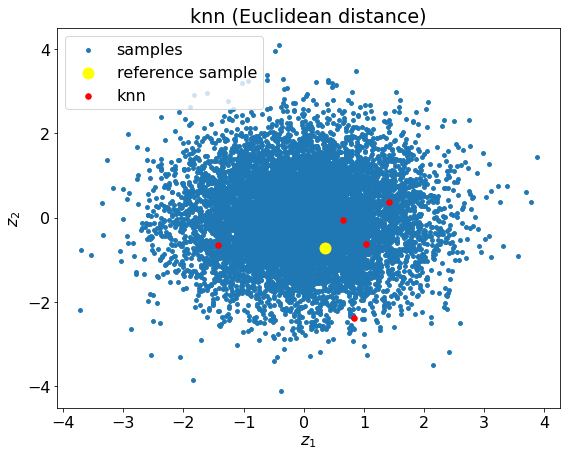

In [71]:
fig = plt.figure(figsize=(9,7))
plt.scatter(noise[:,0], noise[:,1], s=15, label='samples')
plt.scatter(noise[0,0], noise[0,1], s=120, c='yellow', label='reference sample')
plt.scatter(noise[nn,0], noise[nn,1], s=30, c='r', label='knn')
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('knn (Euclidean distance)')
plt.legend()
plt.show()

In [72]:
# Predict compositions for samples and its neighbors with the pretrained PLS models
pred = [] # list 
for i in range(comp.shape[1]):
    pred.append(models_best[i].predict(libs_from_noise[nn].reshape(nn.shape[1], libs_from_noise.shape[1])))

In [73]:
pred_ar = np.array((pred)).reshape(comp.shape[1], nn.shape[1]) # convert list to numpy array
pred_ar.shape

(8, 5)

In [76]:
# Compute mean and max-min
mean = np.mean(pred_ar, axis=1)
p_max = np.amax(pred_ar, axis=1)
p_min = np.amin(pred_ar, axis=1)
std = np.std(pred_ar, axis=1)

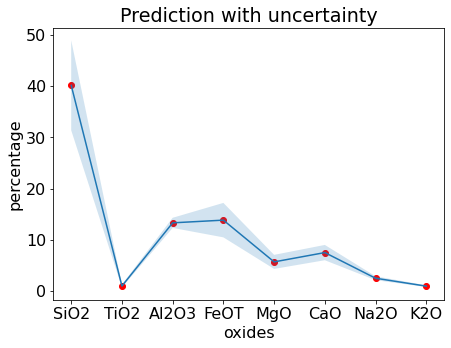

In [77]:
# Plot distributions of predictions
plt.figure(figsize=(7,5))
plt.plot(oxides, mean)
plt.scatter(oxides, mean, c='r')
plt.fill_between(oxides, mean-2*std, mean+2*std, alpha=0.2)
#plt.errorbar(oxides, mean, yerr=p_min + p_max, fmt='-o')
plt.title('Prediction with uncertainty')
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.show()